<a href="https://colab.research.google.com/github/rubygitflow/Sequence-to-Sequence-training-models/blob/master/Copy_1_%22University_of_Artificial_Intelligence_NLP_HomeWork_8_Pro_Attention_mechanism%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP.Lesson 8.Attention mechanism

**Changes in the Copy 1.**

* Improved algorithmic cleaning of the dictionary from garbage.
* Reduced the length of sentences for machine learning.
* Additional training has been moved to after the primary one.

1. Attention: Sequence 2 Sequence model with Attention Mechanism. https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a
2. Визуализируя нейронный машинный перевод (seq2seq модели с механизмом внимания). https://habr.com/ru/post/486158/

Parallel text corpora En-Ru:
*   http://www.wordsbase.com/2016/01/tm-share.html
*   http://ufal.mff.cuni.cz/umc/cer/
*   https://tatoeba.org/



In [1]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, GlobalMaxPooling1D, LSTM, GRU, Bidirectional, Embedding, Input, Concatenate, Attention, Reshape, Lambda, concatenate, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy

import tensorflow.keras.backend as K
from keras.regularizers import l2, l1

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

## Checking the GPU

In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import os
import psutil
import humanize
import GPUtil as GPU
GPUs = GPU.getGPUs()
if len(GPUs)>0:
  gpu = GPUs[0]
else:
  print('GPU turned off')
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM FREE: "+humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  if len(GPUs)>0:
    print("Gen RAM FREE: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    print("GPU Model: " + gpu.name)

printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=662aa9d8bdadddce6f004d10bfd645f87a9155f9944a2227c5bee2e8a53a492e
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM FREE: 26.3 GB  | Proc size: 365.3 MB
Gen RAM FREE: 16280MB | Used: 0MB | Util   0% | Total 16280MB
GPU Model: Tesla P100-PCIE-16GB


## Data Setting

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def highlight_chars(txt):
  # select spetial  chars
  angle_brackets = ['<', '>']
  for elem in angle_brackets:
    txt = txt.replace(elem, ' '+elem+' ')

  # select digits
  txt = re.sub(r'\d\d\.\d\d\.\d{4}', r' <date> ', txt)  # "" 
  txt = re.sub(r'\d\d\.\d\d\.\d\d', r' <date> ', txt)   # "" 
  txt = re.sub(r'\d\d\/\d\d\/\d{4}', r' <date> ', txt)  # "" 
  txt = re.sub(r'\d\d\/\d\d\/\d\d', r' <date> ', txt)   # "" 
  txt = re.sub(r'\d\d:\d\d:\d\d', r' <time> ', txt)     # "" 
  txt = re.sub(r'\d\d-\d\d-\d\d', r' <time> ', txt)     # "" 
  txt = re.sub(r'\d\d—\d\d—\d\d', r' <time> ', txt)     # "" 
  txt = re.sub(r'\d\d–\d\d–\d\d', r' <time> ', txt)     # "" 
  txt = re.sub(r'\d\d:\d\d', r'<time>', txt)          # "" 

  txt = re.sub(r'\d+-\d+', r' <range> ', txt)         #  '4-5'
  txt = re.sub(r'\d+\/\d+', r' <real> ', txt)         # "8/8" 
  txt = re.sub(r'\d+,\d+', r' <real> ', txt)          # "8,8" 
  txt = re.sub(r'\d+\.\d+', r' <number> ', txt)       # "9.8" 
  # for \s-char exclude \t-char
  txt = re.sub(r'-\d+\. ', r' <number> . ', txt)     # "-1. "  
  txt = re.sub(r'–\d+\. ', r' <number> . ', txt)     # "–1. "  
  txt = re.sub(r'—\d+\. ', r' <number> . ', txt)     # "—1. "  
  txt = re.sub(r'\d+\.\n', r' <number> . ', txt)      # "7. "  
  txt = re.sub(r'-\d+\.\n', r' <number> . ', txt)     # "-1. "  
  txt = re.sub(r'–\d+\.\n', r' <number> . ', txt)     # "–1. "  
  txt = re.sub(r'—\d+\.\n', r' <number> . ', txt)     # "—1. "  
  txt = re.sub(r'\d+\.\n', r' <number> . ', txt)      # "7. "  

  txt = re.sub(r'\d+', r' <number> ', txt)      # "17"  

  # select any symbols (manually created list)
  char_list = ['-', '.', ',', '"', '$', '«', 'ø', '%', ')', '&', '−', '≤', '‘', '£', '?', '™', '‚', '(', '*', '№', '•', ';', '½', '’', '/', '+', '±', '>', '“', 'ş', '¦', '–', "'", '€', '#', '§', '”', '@', '‑', ':', '!', '»', '¼', '·', '°', '…', '=', '—']
  refreshed_char_list = [item for item in char_list if item not in angle_brackets]  # very important exclude spetial  chars from list !
  for elem in refreshed_char_list:
    txt = txt.replace(elem, ' '+elem+' ')
    
  return txt

**Here we carry out chars-cleaning iterations**

In [5]:
with open('/content/drive/My Drive/Базы/NLP/English-Russian.1-1.txt', 'r') as f:
  text = f.read()
  text = text.replace('\ufeff', '')  
  text = text.replace('\uf043', ' ')  
  text = text.replace('\x9d', ' ')  
  text = text.replace('\uf029', ' ')  
  text = text.replace('\x81', ' ')  
  text = text.replace('\xad', ' ')  
  text = text.replace('\uf024', ' ')  
  text = text.replace('\x91', ' ')  
  text = text.replace('\uf042', ' ')  
  text = text.replace('\x8d', ' ')  
  text = text.replace('\x80', ' ')  
  text = text.replace('\uf0d4', ' ')  
  text = text.replace('\x90', ' ')  
  text = text.replace('\x8f', ' ')  
  text = text.replace('\uf0b7', ' ')  
  text = text.replace('�', ' ')  
  text = text.replace('', ' ')
  text = highlight_chars(text)

  text_of_chars = re.sub(r'[А-яA-z0-9\n\t<>]', ' ', text) 
  text_of_chars = ' '.join(text_of_chars.split())

In [6]:
chars = list(set(text_of_chars.lower().split(' ')))
len(chars)

84

In [7]:
chars

['î',
 'ґ',
 '§',
 '"',
 'č',
 'ё',
 'ń',
 '•',
 'ô',
 'ö',
 '’',
 '-',
 '»',
 'ú',
 'ï',
 '−',
 'ó',
 'ã',
 'é',
 '‑',
 ')',
 '€',
 '—',
 'ŕ',
 '”',
 '*',
 'ű',
 'â',
 'å',
 'è',
 'ü',
 '½',
 '&',
 '±',
 '!',
 '‘',
 'áš',
 '«',
 'ê',
 'ğ',
 'ό',
 'ří',
 'š',
 'á',
 '¦',
 '+',
 '¼',
 '=',
 '°',
 '.',
 ';',
 '(',
 'ç',
 'β',
 '“',
 'ёё',
 'łę',
 "'",
 'ø',
 '/',
 ':',
 '‚',
 '#',
 '·',
 'ş',
 'ñ',
 '@',
 'ł',
 '…',
 '≤',
 'õ',
 ',',
 'à',
 '™',
 '№',
 '%',
 '£',
 '?',
 '$',
 'ä',
 'ë',
 'í',
 'ć',
 '–']

In [8]:
num_chars = 100 # get all the symbols — http://book.itep.ru/10/ascii.htm
tokenizer = Tokenizer(num_words=num_chars, char_level=True) 
tokenizer.fit_on_texts(chars)
tokenizer.index_word

{1: 'ё',
 2: 'á',
 3: 'š',
 4: 'í',
 5: 'ł',
 6: 'î',
 7: 'ґ',
 8: '§',
 9: '"',
 10: 'č',
 11: 'ń',
 12: '•',
 13: 'ô',
 14: 'ö',
 15: '’',
 16: '-',
 17: '»',
 18: 'ú',
 19: 'ï',
 20: '−',
 21: 'ó',
 22: 'ã',
 23: 'é',
 24: '‑',
 25: ')',
 26: '€',
 27: '—',
 28: 'ŕ',
 29: '”',
 30: '*',
 31: 'ű',
 32: 'â',
 33: 'å',
 34: 'è',
 35: 'ü',
 36: '½',
 37: '&',
 38: '±',
 39: '!',
 40: '‘',
 41: '«',
 42: 'ê',
 43: 'ğ',
 44: 'ό',
 45: 'ř',
 46: '¦',
 47: '+',
 48: '¼',
 49: '=',
 50: '°',
 51: '.',
 52: ';',
 53: '(',
 54: 'ç',
 55: 'β',
 56: '“',
 57: 'ę',
 58: "'",
 59: 'ø',
 60: '/',
 61: ':',
 62: '‚',
 63: '#',
 64: '·',
 65: 'ş',
 66: 'ñ',
 67: '@',
 68: '…',
 69: '≤',
 70: 'õ',
 71: ',',
 72: 'à',
 73: '™',
 74: '№',
 75: '%',
 76: '£',
 77: '?',
 78: '$',
 79: 'ä',
 80: 'ë',
 81: 'ć',
 82: '–'}

In [9]:
char_list = tokenizer.index_word.values()

In [10]:
char_list

dict_values(['ё', 'á', 'š', 'í', 'ł', 'î', 'ґ', '§', '"', 'č', 'ń', '•', 'ô', 'ö', '’', '-', '»', 'ú', 'ï', '−', 'ó', 'ã', 'é', '‑', ')', '€', '—', 'ŕ', '”', '*', 'ű', 'â', 'å', 'è', 'ü', '½', '&', '±', '!', '‘', '«', 'ê', 'ğ', 'ό', 'ř', '¦', '+', '¼', '=', '°', '.', ';', '(', 'ç', 'β', '“', 'ę', "'", 'ø', '/', ':', '‚', '#', '·', 'ş', 'ñ', '@', '…', '≤', 'õ', ',', 'à', '™', '№', '%', '£', '?', '$', 'ä', 'ë', 'ć', '–'])

**End of chars-cleaning iterations**

In [6]:
text_of_lexemes = ' '.join(text.split(' '))

In [7]:
print(text_of_lexemes[:1000])

Musharraf  ’  s Last Act  ? 	Последний ход Мушаррафа  ? 
Desperate to hold onto power  ,  Pervez Musharraf has discarded Pakistan  ’  s constitutional framework and declared a state of emergency  . 	В отчаянном стремлении удержать власть  ,  Первез Мушарраф отверг конституционную систему Пакистана и объявил о введении чрезвычайного положения  . 
Artfully  ,  though shamelessly  ,  he has tried to sell this action as an effort to bring about stability and help fight the war on terror more effectively  . 	Искусно  ,  хотя и бессовестно  ,  он попытался оправдать данное действие стремлением установить стабильность и начать более эффективную борьбу с терроризмом  . 
Nothing could be further from the truth  . 	Это крайне далеко от действительности  . 
If Pakistan  ’  s history is any indicator  ,  his decision to impose martial law may prove to be the proverbial straw that breaks the camel  ’  s back  . 	Если судить по пакистанской истории  ,  его решение установить военное положение может 

In [8]:
dictionary = text_of_lexemes.split('\n')

In [9]:
dictionary.__len__()

85521

In [10]:
# Improved algorithmic cleaning of the dictionary from garbage
en = []
ru = [] 
# provide a protection from obvious garbage
for elem in dictionary:
  dic = elem.split('\t')
  eng = ' '.join(dic[0].split())
  rus = ' '.join(dic[1].split())
  # count of words
  len_en = len(eng.split())
  len_ru = len(rus.split()) 
  if len_en > 4 and len_ru > 4: # this condition was added after learning
    if len_en > len_ru // 2 and len_ru > len_en // 2: #  we consider only meaningful constructions
      if re.search(r'[A-z]+', eng) and re.search(r'[А-я]+', rus): #  we have a real translation
        en.append(eng)
        ru.append(rus)

In [11]:
len(en), len(ru)

(78656, 78656)

In [12]:
length_dictionary = len(en)

In [13]:
ru[993]

'В Италии доля банковских кредитов в процентном отношении к суммарным объемам займов , сделанных большими итальянскими компаниями упала с <number> % до <number> % - такие сильные изменения в основном достигнуты за счет эмиссии промышленных облигаций .'

In [14]:
len(ru[993])

250

In [15]:
ru[:13], en[:13]

(['В отчаянном стремлении удержать власть , Первез Мушарраф отверг конституционную систему Пакистана и объявил о введении чрезвычайного положения .',
  'Искусно , хотя и бессовестно , он попытался оправдать данное действие стремлением установить стабильность и начать более эффективную борьбу с терроризмом .',
  'Это крайне далеко от действительности .',
  'Если судить по пакистанской истории , его решение установить военное положение может оказаться той самой последней каплей из пословицы , которая переполнит чашу терпения народа .',
  'Генерал Мушарраф появился на национальной сцене Пакистана <number> октября <number> года , свергнув законно избранное правительство и объявив о начале амбициозного проекта по « строительству нации » .',
  'Многие пакистанцы , лишённые иллюзий в отношении политического класса Пакистана , молчаливо согласились с его приходом к власти , думая , что он сможет что - то изменить .',
  'Террористические атаки в Америке <number> сентября <number> года позволили

In [ ]:
ru[:length_dictionary]

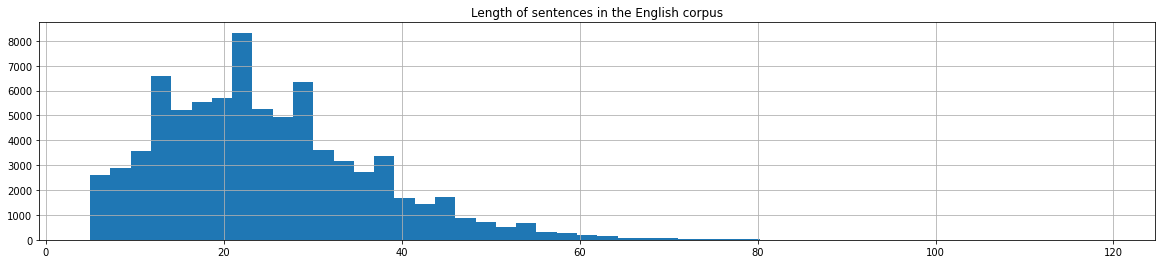

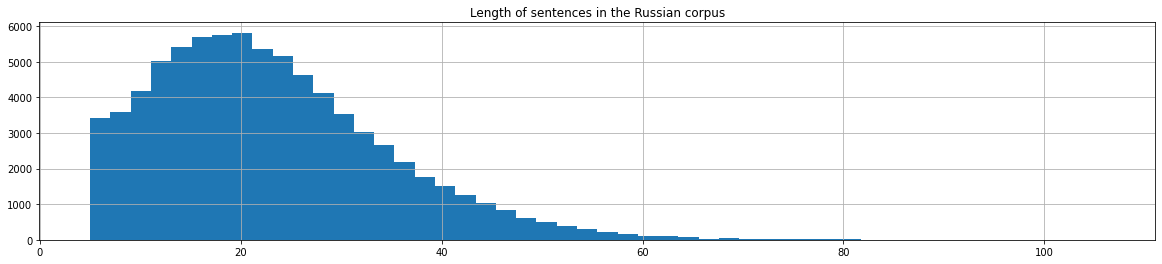

In [17]:
# Let's see which sentence length to choose
sizeEn = []
for i in en:
  sizeEn.append(len(i.split()))
plt.figure(figsize=(20,4))
plt.title('Length of sentences in the English corpus')
plt.hist(sizeEn, bins=50)
plt.grid(True)
plt.show()

sizeRu = []
for i in ru:
  sizeRu.append(len(i.split()))
plt.figure(figsize=(20,4))
plt.title('Length of sentences in the Russian corpus')
plt.hist(sizeRu, bins=50)
plt.grid(True)
plt.show()


In [18]:
min(sizeRu), max(sizeRu), len(sizeRu)

(5, 106, 78656)

In [19]:
min(sizeEn), max(sizeEn), len(sizeEn)

(5, 119, 78656)

In [20]:
enc_in = [q + ' <END>' for q in ru]

In [21]:
enc_in[:13]

['В отчаянном стремлении удержать власть , Первез Мушарраф отверг конституционную систему Пакистана и объявил о введении чрезвычайного положения . <END>',
 'Искусно , хотя и бессовестно , он попытался оправдать данное действие стремлением установить стабильность и начать более эффективную борьбу с терроризмом . <END>',
 'Это крайне далеко от действительности . <END>',
 'Если судить по пакистанской истории , его решение установить военное положение может оказаться той самой последней каплей из пословицы , которая переполнит чашу терпения народа . <END>',
 'Генерал Мушарраф появился на национальной сцене Пакистана <number> октября <number> года , свергнув законно избранное правительство и объявив о начале амбициозного проекта по « строительству нации » . <END>',
 'Многие пакистанцы , лишённые иллюзий в отношении политического класса Пакистана , молчаливо согласились с его приходом к власти , думая , что он сможет что - то изменить . <END>',
 'Террористические атаки в Америке <number> сен

In [22]:
decoder_in = ['<START> ' + a for a in en]
decoder_out = [a + ' <END>' for a in en]

In [23]:
decoder_in[:13]

['<START> Desperate to hold onto power , Pervez Musharraf has discarded Pakistan ’ s constitutional framework and declared a state of emergency .',
 '<START> Artfully , though shamelessly , he has tried to sell this action as an effort to bring about stability and help fight the war on terror more effectively .',
 '<START> Nothing could be further from the truth .',
 '<START> If Pakistan ’ s history is any indicator , his decision to impose martial law may prove to be the proverbial straw that breaks the camel ’ s back .',
 '<START> General Musharraf appeared on the national scene on October <number> , <number> , when he ousted an elected government and announced an ambitious “ nation - building ” project .',
 '<START> Many Pakistanis , disillusioned with Pakistan ’ s political class , remained mute , thinking that he might deliver .',
 '<START> The September <number> , <number> , terrorist attacks on America brought Musharraf into the international limelight as he agreed to ditch the 

In [24]:
decoder_out[:13]

['Desperate to hold onto power , Pervez Musharraf has discarded Pakistan ’ s constitutional framework and declared a state of emergency . <END>',
 'Artfully , though shamelessly , he has tried to sell this action as an effort to bring about stability and help fight the war on terror more effectively . <END>',
 'Nothing could be further from the truth . <END>',
 'If Pakistan ’ s history is any indicator , his decision to impose martial law may prove to be the proverbial straw that breaks the camel ’ s back . <END>',
 'General Musharraf appeared on the national scene on October <number> , <number> , when he ousted an elected government and announced an ambitious “ nation - building ” project . <END>',
 'Many Pakistanis , disillusioned with Pakistan ’ s political class , remained mute , thinking that he might deliver . <END>',
 'The September <number> , <number> , terrorist attacks on America brought Musharraf into the international limelight as he agreed to ditch the Taliban and support 

In [25]:
num_words = 90000 # cut off only a third of the total volume of terms
tokenizer = Tokenizer(num_words, filters='', oov_token='<UNK>') # it's important to include the "filters" param

In [26]:
tokenizer.fit_on_texts(enc_in)
tokenizer.fit_on_texts(decoder_in)
tokenizer.fit_on_texts(decoder_out)

In [27]:
len(tokenizer.index_word)

130440

In [28]:
tokenizer.index_word

{1: '<UNK>',
 2: ',',
 3: '.',
 4: 'the',
 5: '<end>',
 6: 'of',
 7: 'to',
 8: 'and',
 9: '<start>',
 10: 'in',
 11: 'a',
 12: '-',
 13: 'в',
 14: 'и',
 15: 'is',
 16: 'that',
 17: '<number>',
 18: 's',
 19: 'for',
 20: 'as',
 21: '’',
 22: 'it',
 23: 'be',
 24: 'на',
 25: 'are',
 26: 'but',
 27: 'not',
 28: 'with',
 29: 'не',
 30: 'что',
 31: 'on',
 32: 'by',
 33: "'",
 34: 'this',
 35: '–',
 36: 'have',
 37: 'will',
 38: 'has',
 39: 'с',
 40: 'from',
 41: '"',
 42: 'their',
 43: 'at',
 44: 'its',
 45: 'they',
 46: 'an',
 47: 'was',
 48: 'more',
 49: 'or',
 50: 'как',
 51: ':',
 52: '(',
 53: 'к',
 54: ')',
 55: 'us',
 56: 'world',
 57: 'для',
 58: 'по',
 59: 'countries',
 60: 'но',
 61: 'would',
 62: 'than',
 63: 'which',
 64: 'can',
 65: 'if',
 66: 'all',
 67: 'это',
 68: 'one',
 69: 'we',
 70: 'so',
 71: '”',
 72: '“',
 73: '%',
 74: 'europe',
 75: 'new',
 76: 'only',
 77: 'no',
 78: 'his',
 79: 'political',
 80: 'economic',
 81: 'то',
 82: 'been',
 83: ';',
 84: 'из',
 85: 'there'

In [71]:
tokenizer.word_index['deficit']

971

In [72]:
tokenizer.word_index['counci']

KeyError: ignored

In [29]:
X_enc = tokenizer.texts_to_sequences(enc_in)

In [30]:
len(X_enc)

78656

In [31]:
X_dec = tokenizer.texts_to_sequences(decoder_in)
Y = tokenizer.texts_to_sequences(decoder_out)

In [32]:
len(X_dec)

78656

In [33]:
len(Y)

78656

In [34]:
# Finding short sentences in the encoder
# Reduced the length of sentences for machine learning from 70 to 60 words.
threshold = 60
idx_q = [len(y) < threshold for y in X_enc]
sum(idx_q)

78044

In [35]:
X_enc = np.array(X_enc)[idx_q]
X_dec = np.array(X_dec)[idx_q]
Y = np.array(Y)[idx_q]

In [36]:
X_enc.shape, X_dec.shape, Y.shape

((78044,), (78044,), (78044,))

In [37]:
# Finding short sentences in the decoder
idx_a = [len(y) < threshold for y in X_dec]
sum(idx_a)

77574

In [38]:
X_enc = X_enc[idx_a]
X_dec = X_dec[idx_a]
Y = Y[idx_a]

In [39]:
X_enc.shape, X_dec.shape, Y.shape

((77574,), (77574,), (77574,))

In [40]:
max_q_len = max([len(el) for el in X_enc]); max_q_len

59

In [41]:
max_a_len = max([len(el) for el in X_dec]); max_a_len

59

In [42]:
X_enc = pad_sequences(X_enc, max_q_len, padding='post', truncating='post')
X_dec = pad_sequences(X_dec, max_a_len, padding='post', truncating='post')
Y = pad_sequences(Y, max_a_len, padding='post', truncating='post')

In [43]:
print(X_enc.shape)
print(X_dec.shape)
print(Y.shape)

(77574, 59)
(77574, 59)
(77574, 59)


In [44]:
X_enc[5:10]

array([[  407, 54069,     2, 86649, 23654,    13,   627,  1763,  5567,
         5208,     2, 41560, 10030,    39,   133, 18935,    53,   464,
            2, 31028,     2,    30,   167,  1692,    30,    12,    81,
         2768,     3,     5,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [ 6163,  7233,    13,  1156,    17,  2747,    17,   245,  8022,
        31029, 15286,    13,  6164,  2428,    24,  1553,  6403,     2,
          389,   167, 14018,  6404, 15543,    14,  3681,  1856,    39,
         2938,     2, 41561, 26270,  4494,     3,     5,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [ 9180, 86650,  3054,  1393, 31030, 12106,  4377, 243

In [45]:
X_dec[5:10]

array([[    9,   108, 19335,     2, 20897,    28,   987,    21,    18,
           79,  1371,     2,  2026, 32676,     2,  1353,    16,   102,
          285,  2273,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [    9,     4,   988,    17,     2,    17,     2,   845,   837,
           31,   115,  1057,  2617,   129,     4,   123, 39009,    20,
          102,  1863,     7, 25210,     4,  2166,     8,   221,     4,
          233,   159,    12,   499,   124,    31,  1523,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [    9,  2617, 49867,   473,    31,   113,   582,  64

In [46]:
Y[5:10]

array([[  108, 19335,     2, 20897,    28,   987,    21,    18,    79,
         1371,     2,  2026, 32676,     2,  1353,    16,   102,   285,
         2273,     3,     5,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [    4,   988,    17,     2,    17,     2,   845,   837,    31,
          115,  1057,  2617,   129,     4,   123, 39009,    20,   102,
         1863,     7, 25210,     4,  2166,     8,   221,     4,   233,
          159,    12,   499,   124,    31,  1523,     3,     5,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [ 2617, 49867,   473,    31,   113,   582,  6476,  59

# Modelling function

In [47]:
def decode_sequence(inp_str): 
  """
  Displays the generated answer to the question.
  Passing a string to the function
  Returning a string from the function
  """
  inp_str = inp_str + ' <end>'
  example = pad_sequences(tokenizer.texts_to_sequences([inp_str]), maxlen=max_q_len, padding='post')

  # returning the state [h, c]
  states_value, attention = encoder_model.predict(example)

  # creating an array of length pad+1
  target_token = np.zeros((1,1))
  # assigning the value "start" to the first word
  target_token[0,0] = tokenizer.word_index['<start>']

  # stop flag
  Flag = False
  # reset the sentence
  decoded_sentence = ''

  while not Flag:
    pred, *states_value = decoder_model.predict([attention, target_token] + states_value)
    
    # translating the decoded token into a word 
    token_pred = np.argmax(pred, axis=-1) #
    #print(token_pred)
    
    sampled_word = tokenizer.index_word[int(token_pred)]
    #print(sampled_word)
    
    # if a sentence end tag is encountered or its length is exceeded
    if sampled_word == '<end>':
      Flag = True
    else:
      decoded_sentence += sampled_word + ' '

      if len(decoded_sentence.split()) > max_a_len:
        Flag = True
      
    target_token[0,0] = token_pred

  print('Answer:', decoded_sentence[:-6]) 

In [48]:
def pred_train(inp_str): 
  """
  Calculating errors,
  returns a sequence of tokens, as indecoder_out
  """

  # returning the state [h, c]
  states_value, attention = encoder_model.predict(inp_str)

  # creating an array of length pad+1
  target_token = np.zeros((1,1))
  # assigning the value "start" to the first word
  target_token[0,0] = tokenizer.word_index['<start>']
  # stop flag
  Flag = False
  # reset the sentence
  decoded_sentence = []

  while not Flag:
    pred, *states_value = decoder_model.predict([attention, target_token] + states_value)
    
    token_pred = np.argmax(pred, axis=-1) #

    if token_pred == tokenizer.word_index['<end>']:
      Flag = True
    else:
      decoded_sentence.append(token_pred[0][0])

      if len(decoded_sentence) > max_a_len:
        Flag = True
      
    target_token[0,0] = token_pred

  return decoded_sentence

In [49]:
# Compare pred и Y 
def metric(n=100, X_enc=X_enc, Y=Y, max_q_len=max_q_len):
  """
  Accuracy assessment, how many correctly predicted tokens
  """

  pred = []
  summ = []
  for i in range(n):
    pred.append(pred_train(X_enc[None, i]))
  pred_1 = pad_sequences(pred, maxlen=max_q_len, padding='post')
  acc = Accuracy()
  acc.update_state(pred_1, Y[:n])
  return acc.result().numpy()

In [50]:
def prepare_text(text):
  text = highlight_chars(text)
  text_of_lexemes = ' '.join(text.split(' '))
  return text_of_lexemes

In [51]:
def att_for_plot(sentence, enc_seq_len = max_q_len, dec_seq_len = max_a_len): 
  """
  Function for the attention matrix
  sentence = string (query)
  enc_seq_len = encoder length
  dec_seq_len = decoder length
  returns the not transposed attention matrix, 
  returns the encoder and decoder strings
  """

  attention_plot = np.zeros((enc_seq_len, dec_seq_len))

  res_str = sentence + ' <end>'
  example = pad_sequences(tokenizer.texts_to_sequences([res_str]), maxlen=max_q_len, padding='post')

  # returning the state [h, c]
  states_value, attention = encoder_model_.predict(example)

  # creating an array of length pad+1
  target_token = np.zeros((1,1))
  # assigning the value "start" to the first word
  target_token[0,0] = tokenizer.word_index['<start>']

  # stop flag
  Flag = False
  # reset the sentence
  result = ''
  for t in range(enc_seq_len+1):
    if not Flag:
      pred, att, *states_value = decoder_model_.predict([attention, target_token] + states_value)
      
      attention_plot[t] = att
      # print(att)

      # translating the decoded token into the word
      token_pred = np.argmax(pred, axis=-1) #
      #print(token_pred)
      
      sampled_word = tokenizer.index_word[int(token_pred)]
      
      # if the end tag arrives or the sentence length is exceeded
      if sampled_word == '<end>':
        Flag = True
      else:
        result += sampled_word + ' '

        if len(result.split()) > max_a_len:
          Flag = True
        
      target_token[0,0] = token_pred
  return attention_plot, result[:-1], res_str


In [52]:
def plot_attention(attention, sentence, predicted_sentence):
  """
  matshow attention
  """
  fig = plt.figure(figsize=(10,10))
  
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention)
  ax.set_xticklabels(sentence, rotation=90) 
  ax.set_yticklabels(predicted_sentence) 
  ax.set_xticks(np.arange(len(sentence)))
  ax.set_yticks(np.arange(len(predicted_sentence)))
  plt.show()


In [53]:
def plot_heatmaps(inp_str):
  """
  Сonstruction of the attention matrix 
  """
  attention_sentence, result, sentence = att_for_plot(inp_str)
  attention_plot = attention_sentence[:len(result.split(' ')), :len(sentence.split(' '))]
  print('Request: ', inp_str)
  print('Answer:  ', result)
  # decode_sequence(inp_str)
  plot_attention(attention_plot.T, result.split(' '), sentence.split(' '))

#Attention

In [54]:
# Параметры
enc_seq_len = max_q_len
dec_seq_len = max_a_len
hidden_dim = 256
emb_size = 256

# Encoder
encoder_input = Input((enc_seq_len,))
enc_emb = Embedding(num_words, emb_size, name='enc_emb')(encoder_input)
ys, *final_states = LSTM(hidden_dim, return_state=True, return_sequences=True, name='enc_lstm')(enc_emb)


ys_reshaped = Reshape((1, enc_seq_len, hidden_dim))(ys)
ys_repeated = Lambda(lambda l: K.repeat_elements(l, dec_seq_len, 1))(ys_reshaped)

# Decoder
decoder_input = Input((dec_seq_len,))
dec_emb = Embedding(num_words, emb_size, name='emb')(decoder_input)

dec_lstm = LSTM(hidden_dim, return_sequences=True, name='dec_lstm')(dec_emb, initial_state = final_states)

# Attention
dec_lstm_reshaped = Reshape((dec_seq_len, 1, hidden_dim))(dec_lstm)
conc = concatenate([ys_repeated, dec_lstm_reshaped], axis=-2)
conc_reshaped = Reshape((dec_seq_len, hidden_dim*(enc_seq_len+1)))(conc)

gates = Dense(enc_seq_len, activation='softmax', kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001), name= 'dense_att')(conc_reshaped)
gates_reshaped = Reshape((dec_seq_len, enc_seq_len, 1))(gates)
gates_repeated = Lambda(lambda l: K.repeat_elements(l, hidden_dim, -1))(gates_reshaped)

dot_product = Lambda(lambda xy: K.sum(xy[0]*xy[1], axis=-2))([ys_repeated, gates_repeated])
attentive_state = concatenate([dec_lstm, dot_product])

# Exit
word_probabilities = Dense(num_words, activation='softmax', name= 'dense')(attentive_state)


model = Model([encoder_input, decoder_input], [word_probabilities])

In [55]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 59)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 59)]         0                                            
__________________________________________________________________________________________________
enc_emb (Embedding)             (None, 59, 256)      23040000    input_1[0][0]                    
__________________________________________________________________________________________________
emb (Embedding)                 (None, 59, 256)      23040000    input_2[0][0]                    
_______________________________________________________________________________________

## Primary training. 

In [56]:
callback_ = EarlyStopping(monitor='val_accuracy', patience=4)
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=RMSprop(lr = 0.01))
model.fit([X_enc, X_dec], Y, epochs=5, callbacks=callback_,  batch_size=80, validation_split=0.2)
model.save('/content/drive/My Drive/tmp/attention_seq2seq.h5' )

Epoch 1/5
776/776 [==============================] - 614s 791ms/step - loss: 6.9372 - accuracy: 0.6727 - val_loss: 6.5674 - val_accuracy: 0.6957
Epoch 2/5
776/776 [==============================] - 612s 789ms/step - loss: 6.4935 - accuracy: 0.7057 - val_loss: 6.5328 - val_accuracy: 0.7073
Epoch 3/5
776/776 [==============================] - 612s 788ms/step - loss: 6.3823 - accuracy: 0.7205 - val_loss: 6.5195 - val_accuracy: 0.7142
Epoch 4/5
776/776 [==============================] - 612s 788ms/step - loss: 6.3146 - accuracy: 0.7293 - val_loss: 6.5409 - val_accuracy: 0.7149
Epoch 5/5
776/776 [==============================] - 611s 787ms/step - loss: 6.2774 - accuracy: 0.7355 - val_loss: 6.5373 - val_accuracy: 0.7157


In [ ]:
# Download weights
# model = load_model('/content/drive/My Drive/tmp/attention_seq2seq.h5' )

## Additional training.

In [57]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=RMSprop(lr = 0.001))
model.fit([X_enc, X_dec], Y, epochs=10, callbacks=callback_,  batch_size=80, validation_split=0.2)
model.save('/content/drive/My Drive/tmp/attention_seq2seq.h5' )

Epoch 1/10
776/776 [==============================] - 612s 788ms/step - loss: 1.8838 - accuracy: 0.7622 - val_loss: 2.3263 - val_accuracy: 0.7245
Epoch 2/10
776/776 [==============================] - 612s 788ms/step - loss: 1.7762 - accuracy: 0.7736 - val_loss: 2.3421 - val_accuracy: 0.7240
Epoch 3/10
776/776 [==============================] - 606s 781ms/step - loss: 1.7205 - accuracy: 0.7812 - val_loss: 2.3537 - val_accuracy: 0.7239
Epoch 4/10
776/776 [==============================] - 604s 779ms/step - loss: 1.6776 - accuracy: 0.7872 - val_loss: 2.3702 - val_accuracy: 0.7228
Epoch 5/10
776/776 [==============================] - 603s 777ms/step - loss: 1.6420 - accuracy: 0.7926 - val_loss: 2.3851 - val_accuracy: 0.7220


## Inference

In [58]:
enc_seq_len = max_q_len
dec_seq_len = 1
# Input
encoder_reshaped = Input((dec_seq_len, enc_seq_len,hidden_dim,))
decoder_state_input_h = Input((hidden_dim,))
decoder_state_input_c = Input((hidden_dim,))
final_st = [decoder_state_input_h, decoder_state_input_c]
decoder_input = Input((dec_seq_len,))

# Decoder
dec_emb = Embedding(num_words, emb_size, name='emb')(decoder_input)
dec_lstm, *states_value = LSTM(hidden_dim, return_state=True, name='dec_lstm')(dec_emb, initial_state = final_st)

# Attention
dec_resh = Reshape((dec_seq_len, hidden_dim))(dec_lstm)
dec_lstm_reshaped = Reshape((dec_seq_len, 1, hidden_dim))(dec_resh)
conc = concatenate([encoder_reshaped, dec_lstm_reshaped], axis=-2)
conc_reshaped = Reshape((dec_seq_len, hidden_dim*(enc_seq_len+1)))(conc)

gates = Dense(enc_seq_len, activation='softmax', name= 'dense_att')(conc_reshaped)
gates_reshaped = Reshape((dec_seq_len, enc_seq_len, 1))(gates)
gates_repeated = Lambda(lambda l: K.repeat_elements(l, hidden_dim, -1))(gates_reshaped)

dot_product = Lambda(lambda xy: K.sum(xy[0]*xy[1], axis=-2))([encoder_reshaped, gates_repeated])

attentive_state = concatenate([dec_resh, dot_product])

# Exit
word_probabilities = Dense(num_words, activation='softmax', name= 'dense')(attentive_state)

# Create models
decoder_model = Model([encoder_reshaped, decoder_input]+final_st, [word_probabilities] + states_value)
encoder_model = Model(encoder_input, [final_states, ys_reshaped])

# Transferring weights
for name in ['emb', 'dec_lstm', 'dense', 'dense_att']:
  decoder_model.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())

# If the weights were loaded, then the weights of the encoder must also be transferred 
for name in ['enc_emb', 'enc_lstm']:
  encoder_model.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())


In [59]:
print('Correctly predicted tokens: ', round(metric(100)*100, 2), '%', sep='')

Correctly predicted tokens: 52.85%


Correctly predicted tokens: 

* Primary training. 5 epochs
* Additional training. +5 epochs — 52.85%

In [60]:
decode_sequence('какой вкусный пирог')


Answer: the eu is a member of the european parliam


In [61]:
decode_sequence('Ежегодный Всемирный экономический форум по праву воспринимают как глобальный « барометр » .')

Answer: the global economic forum is growing at the global economic forum , as “ global economic opinion ” is just as a glo


In [62]:
for n in range(1, 50, 5):
  print('------', enc_in[n][:-5])
  decode_sequence(enc_in[n])
  print('------', decoder_out[n][:-5])
  print('-'*40)

------ Искусно , хотя и бессовестно , он попытался оправдать данное действие стремлением установить стабильность и начать более эффективную борьбу с терроризмом . 
Answer: the internet has been even though the war has been a direct consequence of the proposed war with terrorism and the wider 
------ Artfully , though shamelessly , he has tried to sell this action as an effort to bring about stability and help fight the war on terror more effectively . 
----------------------------------------
------ Террористические атаки в Америке <number> сентября <number> года позволили Мушаррафу попасть в центр внимания на международной арене , поскольку он согласился уничтожить Талибан и поддержать войну с терроризмом , возглавляемую Соединёнными Штатами . 
Answer: the terrorist attacks on america ’ s terrorist attacks on september <number> , <number> , united states , on the international front , has agreed to support the united states , and the taliban , the united states has declared support fo

In [63]:
for n in range(100, 150, 5):
  print('------', enc_in[n][:-5])
  decode_sequence(enc_in[n])
  print('------', decoder_out[n][:-5])
  print('-'*40)

------ Он живет в Дамаске , где является одним из руководителей небольшого издания Этана Пресс . 
Answer: he is where he is where he is where he is going to
------ Ammar Abdulhamid is a Syrian novelist and social analyst living in Damascus , where he co - runs a small publishing house , Etana Press . 
----------------------------------------
------ Реальность , тщательно запрятанная под внешней однородностью , всегда была слишком сложной даже для самых проницательных исследователей . 
Answer: the reality , of course , is a , a , a , a , even too , even if the current account probably of a " eve
------ The realities , meticulously hidden under a veneer of homogeneity , have always been too complex for even the most discerning of scholars . 
----------------------------------------
------ В результате до правящих кругов , ранее лишённых чувства реальности , наконец начала доходить необходимость радикальных изменений в структуре и стиле режима . 
Answer: as a result , the end of the day ,

## Attention matrix

In [64]:
# Inference with the attention matrix

enc_seq_len = max_q_len
dec_seq_len = 1 

# Input
encoder_reshaped = Input((dec_seq_len, enc_seq_len,hidden_dim,))
decoder_state_input_h = Input((hidden_dim,))
decoder_state_input_c = Input((hidden_dim,))
final_st = [decoder_state_input_h, decoder_state_input_c]
decoder_input = Input((dec_seq_len,))

# Decoder
dec_emb = Embedding(num_words, emb_size, name='emb')(decoder_input)
dec_lstm, *states_value = LSTM(hidden_dim, return_state=True, name='dec_lstm')(dec_emb, initial_state = final_st)

# Attention
dec_resh = Reshape((dec_seq_len, hidden_dim))(dec_lstm)
dec_lstm_reshaped = Reshape((dec_seq_len, 1, hidden_dim))(dec_resh)
conc = concatenate([encoder_reshaped, dec_lstm_reshaped], axis=-2)
conc_reshaped = Reshape((dec_seq_len, hidden_dim*(enc_seq_len+1)))(conc)

# Output with Dense is needed for the attention matrix
gates = Dense(enc_seq_len, activation='softmax', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), name= 'dense_att')(conc_reshaped)

gates_reshaped = Reshape((dec_seq_len, enc_seq_len, 1))(gates)
gates_repeated = Lambda(lambda l: K.repeat_elements(l, hidden_dim, -1))(gates_reshaped)

dot_product = Lambda(lambda xy: K.sum(xy[0]*xy[1], axis=-2))([encoder_reshaped, gates_repeated])

attentive_state = concatenate([dec_resh, dot_product])

# Output for inference
word_probabilities = Dense(num_words, activation='softmax', name= 'dense')(attentive_state)

# Creating models
decoder_model_ = Model([encoder_reshaped, decoder_input]+final_st, [word_probabilities, gates] + states_value)
encoder_model_ = Model(encoder_input, [final_states, ys_reshaped])

for name in ['emb', 'dec_lstm', 'dense', 'dense_att']:
  decoder_model_.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())
for name in ['enc_emb', 'enc_lstm']:
  encoder_model_.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())

Request:  Дебаты были жаркими.
Answer:   debates were usually were .


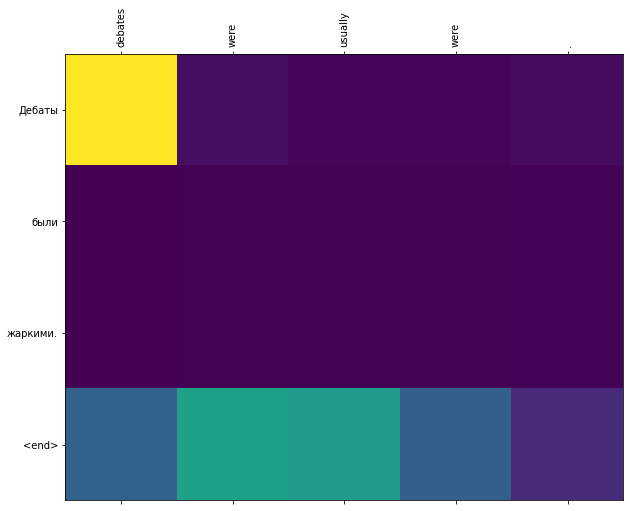

In [65]:
request_str = 'Дебаты были жаркими.'
plot_heatmaps(request_str)

Request:  Образование в этом мире меня разочаровывает
Answer:   education is the world ' s leading i .


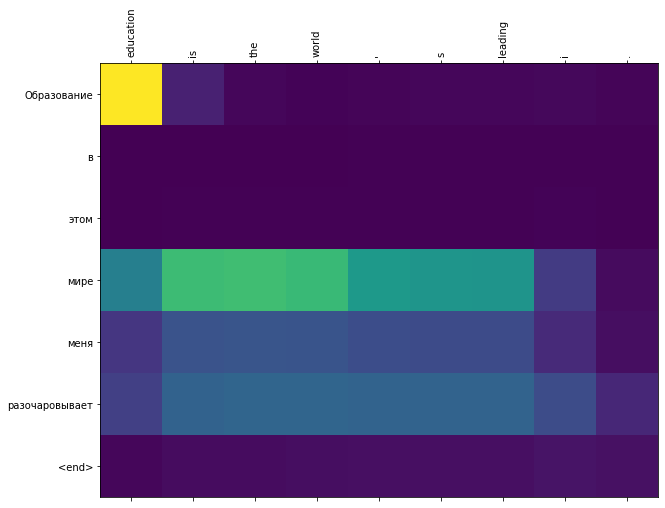

In [66]:
request_str = 'Образование в этом мире меня разочаровывает'
plot_heatmaps(request_str)

Request:  Привет, как дела?
Answer:   as a result , as the


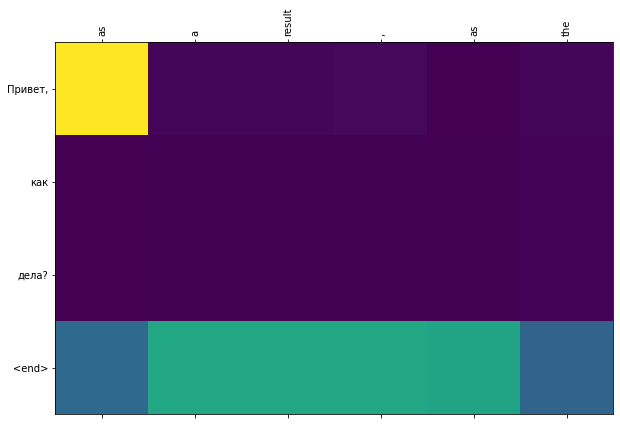

In [67]:
request_str = 'Привет, как дела?'
plot_heatmaps(request_str)

Request:  Один раз в жизни я делаю хорошее дело... И оно бесполезно.
Answer:   one of the life - saving of life and i am living in the treasury i . e . ,


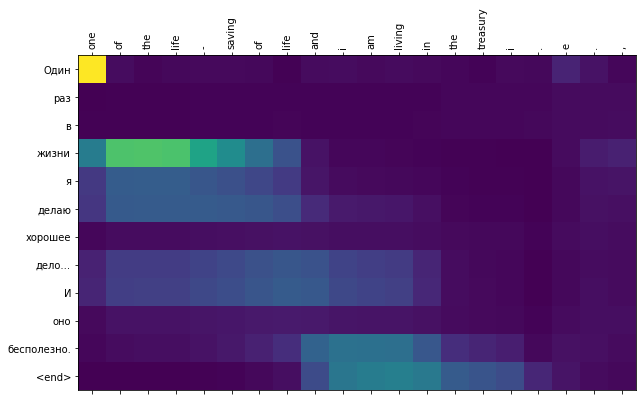

In [68]:
request_str = 'Один раз в жизни я делаю хорошее дело... И оно бесполезно.'
plot_heatmaps(request_str)

## Conclusions
1. Результат не подтверил ожидания. Переводы мало похожи на таковые.
2. В большинстве случаев начало предложений похоже на перевод, но к концу предложения возникает мусор, иногда из последовательного перебора ограниченной  последовательности слов. Вероятно, необходимо осуществлять обучение нейронной сети итерационно на разных длинах предложений. 
3. В исходном тексте существует большое количество именных сокращений. Их частотность достаточно велика, однако их место применения ограничено, что не поняла нейронка. Эти сокращения появляются в переводе где ни попадя.
4. Вопросительные знаки препинания не переносятся в перевод. Иногда предложения с переводом заканчиваются запятой, когда в исходном текте стоит точка. По всей видимости, требуется специальное обучение правилам расстановки знаков препинания.
5. Иногда в переводе обрезается последнее слово. Причём обрезанные слова отсутствуют в словаре. Значит в алгоритме предсказания перевода присутствует ошибка. 

Общее резюме.
* Переводческая база оказалась слишком сложной для обучения. 130 тыс уникальных лексем на 160 тыс. фраз (рус+англ) — вероятно, слишком маленький объём для обучения. 
* Для такого ограниченного объёма базы для обучения очевидна необходимость применения техники нормализации слов с целью создания подстрочника к тексту. Соответственно алгоритм перевода должен быть дополнен алгоритмом обратной лемматизации на этапе отображения перевода текста.
* Возможно, что обучение необходимо проводить на принципах дообучения от простых фраз к сложносочинённым. Тогда возникает необходимость переподготовки переводческой базы. 
* Для создания качественного переводчика очевидна необходимость в реализации поэтапного разбора текста от графематической структуры до его семантической структуры на одном языке с последующей обратной реконструкцией от семантики к графематике на другом языке.

